# Diamanter

Jag har fått i uppdrag av ledningen på Guldfynd att analysera ett dataset från en diamantgrossist, innehållande relevanta priser och specifikationer för olika typer av diamanter. 

**Syftet** med analysen är att utvärdera potentiella investeringsmöjligheter för företaget, med fokus på att undersöka förutsättningarna för att inkludera diamantsmycken i vårt produktsortiment.

**Målet** är att tydligt en identifiera strategi över vilka typer av diamanter som utgör de mest attraktiva investeringsalternativen, samt att kunna, genom att använda strategin, peka ut specifika exemplar i grossistens dataset som bedöms vara särskilt fördelaktiga att investera i just nu.

## Bakgrund

Diamanter är en av världens mest eftertraktade ädelstenar och används i allt från smycken till industriverktyg. För företag som överväger att investera i diamanter är det avgörande att förstå vilka faktorer som styr prisbilden, hur marknaden fungerar och vilka risker och möjligheter som finns.

### Diamant värdering görs genom att dela in i 4st C:
* **Carat** _(vikt)_: Ju högre vikt, desto mer sällsynt och värdefull är diamanten. Dock stiger priset inte enbart linjärt, små skillnader i carat kan ge stora prisvariationer.

* **Cut** _(slipning)_: Slipningen avgör hur ljuset reflekteras i diamanten, vilket påverkar dess briljans och visuell kvalitet. <br>Normal ordning är: Excellent, Very Good, Good, Fair, Poor Men i datasettet representeras dessa enligt följande.<br>Excellent = Ideal,<br> Very Good = Premium,<br> Good = Very Good,<br> Fair = Good,<br> Poor = Fair

* **Color** _(färg)_: I kontrast till informationen i det PDF-dokument jag tagit del av (diamonds_info), är de mest eftertraktade diamanterna de som är helt färglösa. Färg graderas enligt den internationella GIA-skalan från D (helt färglös) till Z (tydlig gul ton), där D representerar den högsta färgkvaliteten.

* **Clarity** _(klarhet)_: Mått på inre och yttre defekter (inklusioner). Ju färre defekter, desto högre värde.

### Marknadsaspekter att beakta:
* **Prisvariationer**: Två diamanter med liknande carat kan skilja kraftigt i pris beroende på färg, klarhet och slipning.

* **Efterfrågan**: Konsumenter tenderar att föredra vissa specifikationer beroende på trender, kulturella preferenser och köpkraft.

## Analys

I analysen av datasettet kommer vi att gå igenom:  
1. Bortagning av felaktig data.  
2. Överblick över datasettet.  
3. Målgruppsspecifiering.   
4. Volatilitet.  
5. Investeringskategorier.  
6. Investeringsmöjligheter i det aktuella datasettet.  
7. Återkoppling till målet.

Jag kommer börja med att visa hur jag uteslöt felaktig data i datasettet.

#### 1. Bortagning av felaktig data

Detta är en funktion som tar bort felaktig data.

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

def clean_diamond_data(df):
    total_start = df.shape[0]
    removed = {}
    allowed_colors = ['D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
    allowed_clarities = [
    'FL',
    'IF',
    'VVS1', 'VVS2',
    'VS1', 'VS2',
    'SI1', 'SI2', 'SI3',
    'I1', 'I2', 'I3'
]
    allowed_cuts = ["Ideal", "Premium", "Very Good", "Good", "Fair"]

    if 'index' not in df.columns:
        df.reset_index(inplace=True)

    before = df.shape[0]
    df = df.dropna(subset=['index', 'cut', 'color', 'clarity', 'price', 'carat', 'x', 'y', 'z', 'depth'])
    removed["Saknade värden"] = before - df.shape[0]

    numeric_cols = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
    before = df.shape[0]
    for col in numeric_cols:
        df = df[df[col] > 0]
    removed["Nollvärden i numeriska kolumner"] = before - df.shape[0]

    before = df.shape[0]
    df = df[(df['x'] <= 15) & (df['y'] <= 15) & (df['z'] <= 15)]
    removed["Extrema mått (>15 mm)"] = before - df.shape[0]

    before = df.shape[0]
    df = df[~((df['carat'] < 1) & (df['z'] > 10))]
    removed["Misstänkt djup (carat < 1 & z > 10)"] = before - df.shape[0]

    df['depth_calc'] = (df['z'] / ((df['x'] + df['y']) / 2)) * 100
    df['depth_diff'] = abs(df['depth_calc'] - df['depth'])
    before = df.shape[0]
    df = df[df['depth_diff'] <= 1]
    removed[">1% avvikelse i depth"] = before - df.shape[0]

    before = df.shape[0]
    df = df[df['cut'].isin(allowed_cuts)]
    removed["Ogiltiga 'cut'-värden"] = before - df.shape[0]

    before = df.shape[0]
    df = df[df['color'].isin(allowed_colors)]
    removed["Ogiltiga 'color'-värden"] = before - df.shape[0]

    before = df.shape[0]
    df = df[df['clarity'].isin(allowed_clarities)]
    removed["Ogiltiga 'clarity'-värden"] = before - df.shape[0]

    print("Sammanställning av borttagna rader:")
    for reason, quant in removed.items():
        print(f"- {reason}: {quant} rader")

    total_borttagna = total_start - df.shape[0]
    print(f"\nTotalt borttagna rader: {total_borttagna}")
    print(f"Rader kvar: {df.shape[0]}")

    return df

df = clean_diamond_data(pd.read_csv("Mockdata_real_set_ok.csv", sep=";"))


df['index'] = df['index'].astype(int)

Sammanställning av borttagna rader:
- Saknade värden: 74 rader
- Nollvärden i numeriska kolumner: 22 rader
- Extrema mått (>15 mm): 3 rader
- Misstänkt djup (carat < 1 & z > 10): 0 rader
- >1% avvikelse i depth: 77 rader
- Ogiltiga 'cut'-värden: 0 rader
- Ogiltiga 'color'-värden: 0 rader
- Ogiltiga 'clarity'-värden: 0 rader

Totalt borttagna rader: 176
Rader kvar: 53764


**Vad vi ser**  
Jag har utvecklat en funktion som rengör datasettet genom att stegvis filtrera bort diamanter som:  
1. Saknar nödvändiga värden  
2. Har nollvärden i fysiska mått (x, y, z)  
3. Uppvisar extrema dimensioner (över 15 mm)  
4. Har oproportionerligt stort djup i förhållande till sin vikt (carat < 1 och z > 10 mm)  
Uppvisar en avvikelse på mer än 1 % mellan angivet djup och det geometriskt beräknade djupet  

**Varför detta görs**  
Detta görs för att säkerställa att den fortsatta analysen baseras på ett så korrekt och tillförlitligt underlag som möjligt.  

**Nästa Steg**  
Jag kommer att fortsätta med att demonstrera en överblick över datasettet.

### 2. Överblick över datasettet

I detta stycke skapar jag en överblick över datasettet

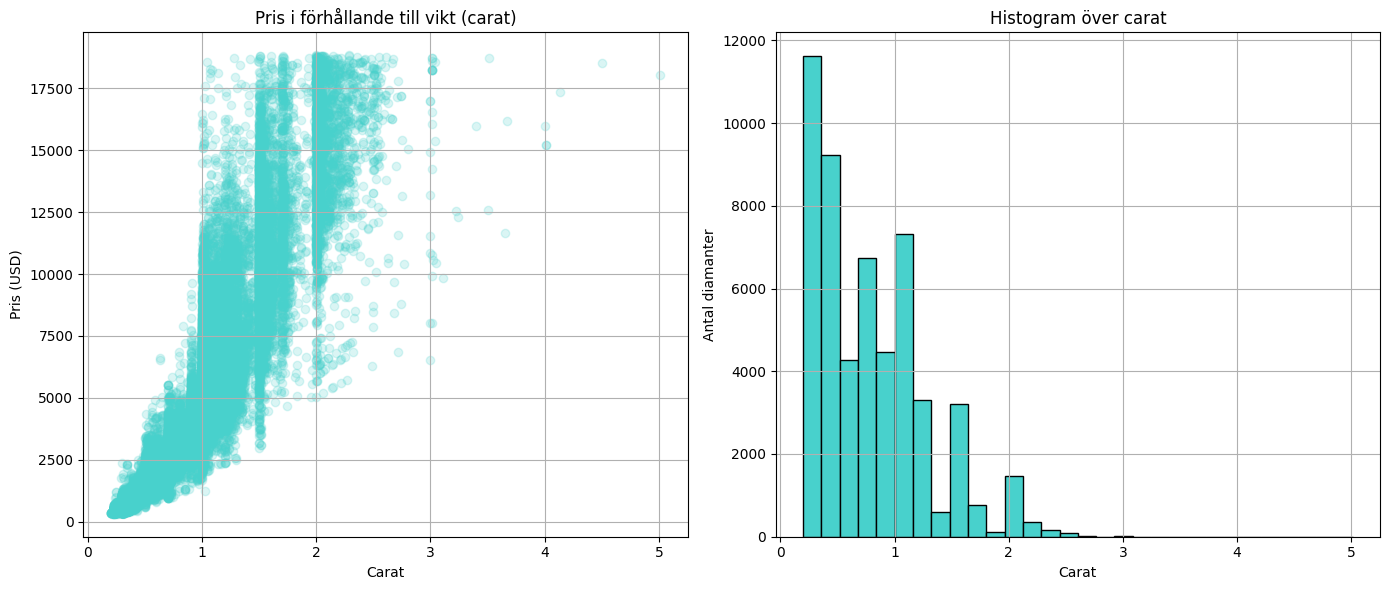

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].scatter(df['carat'], df['price'], alpha=0.2, color='mediumturquoise')
ax[0].set_title('Pris i förhållande till vikt (carat)')
ax[0].set_xlabel('Carat')
ax[0].set_ylabel('Pris (USD)')
ax[0].grid(True)

ax[1].hist(df['carat'], bins=30, color='mediumturquoise', edgecolor='black')
ax[1].set_title('Histogram över carat')
ax[1].set_xlabel('Carat')
ax[1].set_ylabel('Antal diamanter')
ax[1].grid(True)

plt.tight_layout()
plt.show()
correlation = df['carat'].corr(df['price'])

**Vad vi ser**  
I de två översiktsdiagrammen framgår det att majoriteten av diamanterna väger under 1 carat, och att priset har en korrelation på 0.92 med caratvärdet.

Vi kan även se att vid vissa specifika viktgränser, såsom 1.0, 1.5 och 2.0 carat, tenderar priserna att vara både högre och mer utspridda jämfört med närliggande caratnivåer. Detta tyder på att dessa caratgränser har ett särskilt marknadsvärde eller efterfrågemönster.

**Varför detta görs**  
Detta görs för att få en klar bild över hur datasettets diamanter är fördelade och få fram övergripande korrelationer i datan. 

**Nästa steg**  
I nästa steg kommer jag att specificera en målgrupp för Guldfynd.

### 3. Målgruppsspecifiering

I detta stycke kommer målgruppen att specifieras.

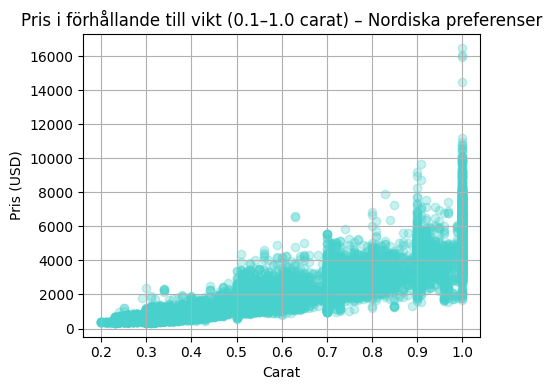

In [34]:
nordic_df = df[(df['carat'] >= 0.1) & (df['carat'] <= 1.0)].copy()

if 'index' not in nordic_df.columns:
    nordic_df.reset_index(inplace=True)
nordic_df['index'] = nordic_df['index'].astype(int)

plt.figure(figsize=(5, 4))
plt.scatter(nordic_df['carat'], nordic_df['price'], alpha=0.3, color='mediumturquoise')
plt.title('Pris i förhållande till vikt (0.1–1.0 carat) – Nordiska preferenser')
plt.xlabel('Carat')
plt.ylabel('Pris (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

**Vad vi ser**  
Efter en genomförd marknadsanalys framgår det att diamanter under 1.0 carat är vanligast förekommande i smyckesproduktion.

I Norden präglas efterfrågan av mer återhållsamma preferenser, vigselringar innehåller vanligtvis diamanter på mellan 0.3 och 1.0 carat, medan andra smycken som örhängen, halsband och armband ofta använder ännu mindre diamanter.

I kontrast till detta är diamanter på 1.5, 2 och 3.0 carat betydligt vanligare i exempelvis den amerikanska marknaden, där större stenar ofta förekommer i vigselringar.

Diamanter över 3 carat är relativt ovanliga inom traditionell smyckesdesign och återfinns främst i investeringssyfte.  

**Varför görs detta**  
Detta görs för att specificera en tydlig ingång i var Guldfynd bör investera kopplat till carat som diamanterna har.

**Rekommendationer**
Mot denna bakgrund rekommenderas att vi på Guldfynd fokuserar på diamanter i spannet 0.1–1.0 carat. Detta kommer att medföra nackdelen att Guldfynd inte erbjuda extremt unika och exsklusiva diamater, tex en diamant på 3 carat. Men målgruppen vi har i nordiska länder stärker bilden av att 0.1-1.0 är det carat spannet vi bör lägga fokus på.  

**Nästa steg**  
I nästa steg kommer jag utgå från behovet som finns på marknaden utefter marknadsanalysen jag gjort på olika hemsidor. Jag kommer även koppla det mot företagets bild utåt.

#### 3.1 Efterfrågan och företagsbild

**Vad vi ser**  
Diamanter med synliga inneslutningar eller missfärgningar uppfattas generellt som mindre exklusiva och kan påverka kundens upplevelse negativt. Det visuella spelar stor roll för en kund, alltså clarity, vilket motsvarar klarheten i diamanten, color vilket är färgen med ofärgad som högst eftertraktad (D). Cut som motsvarar slipningen är däremot inte lika synligt för kunden eftersom det påverkar endast reflektionen i diamanten.    

**Varför görs detta**  
Detta görs för att tillse att Guldfynd väljer rätt diamant egenskaper att investera i kopplat till både behovet på marknaden och företagets bild utåt.  

**Rekommendationer**  
För att upprätthålla Guldfynds standard som en kvalitetsleverantör bör vi undvika att inkludera diamanter som upplevs som smutsiga, suddiga eller färgförändrade.
Jag rekommenderar därför att vi enbart investerar i diamanter med hög klarhet (clarity), så låg färggrad som möjligt samt god slipning (cut). Detta säkerställer att våra smycken håller en hög visuell standard och stärker kundens förtroende för varumärket.  

**Nästa steg**  
Eftersom både datamängden och omvärldsanalysen visar att det finns ett stort utbud av diamanter inom det aktuella spannet, krävs en tydlig strategi för att identifiera de alternativ där företaget har möjlighet att uppnå god lönsamhet.

Därför kommer vi nu att undersöka prisvolatiliteten inom detta segment med clarity, färg och cut i åtanke, för att identifiera var de mest gynnsamma investeringsmöjligheterna finns. Som vi sett i föregående diagram så samlas plottarna i storlek 0.01 carat och därför kommer vi att dela in diamanterna i intervallet 0.01 carat. 

### 4. Volatilitet

Jag kommer att räkna ut vilka grupper(inom color, clarity och cut) som är mest volatila kopplat till dess carat intervall. 

#### 4.1 Funktion för uträkning av volatilitet

In [42]:
def calculate_volatility_groups(df, group_column="color", visualize=True):
    df = df.copy()

    if group_column not in df.columns:
        print(f"❌ Kolumnen '{group_column}' finns inte i DataFrame.")
        return None

    if 'carat_bin' not in df.columns:
        df['carat_bin'] = pd.cut(df['carat'], bins=np.arange(0.1, 1, 0.01))

    try:
        grouped = df.groupby(['carat_bin', group_column], observed=False)['price'].agg(['mean', 'std'])
        grouped['variation'] = grouped['std'] / grouped['mean']
        grouped = grouped.dropna()

        sorted_grouped = grouped.sort_values(['carat_bin', 'variation'], ascending=[True, False])
        top2_per_bin = sorted_grouped.groupby(level='carat_bin', observed=True).head(3)

        full_freq = top2_per_bin.reset_index()[group_column].value_counts()
        topp2 = full_freq.head(3)

        if visualize:
            plt.figure(figsize=(5, 3))
            color_map = {
                "color": "mediumturquoise",
                "clarity": "blue",
                "cut": "skyblue"
            }
            plot_color = color_map.get(group_column, "skyblue")
            full_freq.plot(kind='bar', color=plot_color, edgecolor='black')
            plt.title(f'Frekvens av {group_column} bland mest volatila per carat-intervall')
            plt.xlabel(group_column.capitalize())
            plt.ylabel('Antal gånger i topp 2')
            plt.xticks(rotation=45 if group_column == "cut" else 0)
            plt.grid(axis='y', linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show()

        return topp2, full_freq

    except Exception as e:
        return None


#### 4.2 Volatiliteten grupperat i color

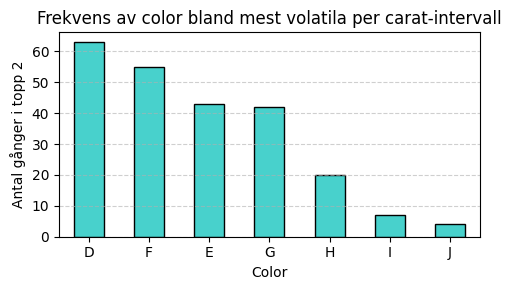

In [45]:
topp2_colors, all_colors = calculate_volatility_groups(nordic_df, group_column="color")

#### 4.3 Volatiliteten grupperat i clarity

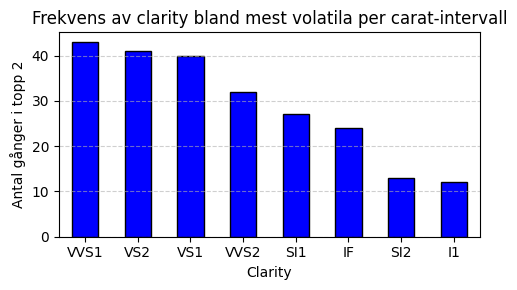

In [48]:
topp2_clarity, all_clarities = calculate_volatility_groups(nordic_df, group_column="clarity")

#### 4.4 Volatiliteten grupperat i cut

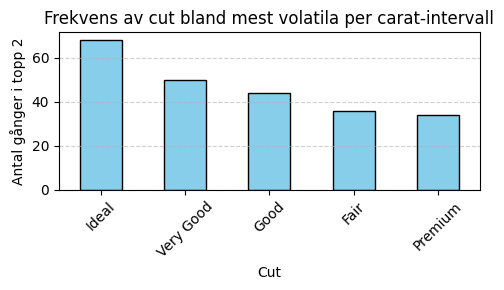

In [51]:
topp2_cut, all_cuts = calculate_volatility_groups(nordic_df, group_column="cut")

**Vad vi ser**  
I dessa beräkningar har jag tagit ut de två kategorier som har högst volatilitet i pris, inom color, clarity och cut.

**Varför görs detta**  
Detta görs för att kunna veta vilka egenskaper en diamant med hög volatilitet oftast har.

**Rekommendationer**
Baserat på beräkningarna ovan framgår det att diamanter med vissa specifika attribut uppvisar olika grad av prisvolatilitet.

En diamant med egenskaperna

Color: D

Clarity: VVS1

Cut: Ideal

uppvisar den högst volatiliteten i pris och kan därför vara en rimlig sortering att utgå från för att hitta billiga diamanter.

**Nästa steg**  
I nästa steg kommer jag sammanställa de mest volatila grupperna för att skapa en tydlig sorteringsstrategi för att hitta de mest prisvärda diamanterna.

### 5. Investeringskategorier

I detta avsnitt sammanställer jag kategorier utifrån volatiliten i de olika egenskaperna

In [56]:
filtered = nordic_df.copy()

if 'carat_bin' not in filtered.columns:
    filtered['carat_bin'] = pd.cut(filtered['carat'], bins=np.arange(0.1, 1, 0.01))

filtered = filtered[
    (filtered['color'].isin(['D', 'F', 'E'])) &
    (filtered['clarity'].isin(['VVS1', 'VS2', 'VS1'])) &
    (filtered['cut'].isin(['Ideal', 'Good', 'Very Good']))
]

kombinationer = filtered.groupby(['color', 'clarity', 'cut']).size().reset_index(name='antal')
print(kombinationer)

   color clarity        cut  antal
0      D     VS1       Good     34
1      D     VS1      Ideal    316
2      D     VS1  Very Good    157
3      D     VS2       Good     84
4      D     VS2      Ideal    864
5      D     VS2  Very Good    260
6      D    VVS1       Good     13
7      D    VVS1      Ideal    137
8      D    VVS1  Very Good     46
9      E     VS1       Good     73
10     E     VS1      Ideal    548
11     E     VS1  Very Good    248
12     E     VS2       Good    123
13     E     VS2      Ideal   1058
14     E     VS2  Very Good    402
15     E    VVS1       Good     41
16     E    VVS1      Ideal    310
17     E    VVS1  Very Good    157
18     F     VS1       Good    115
19     F     VS1      Ideal    490
20     F     VS1  Very Good    223
21     F     VS2       Good    138
22     F     VS2      Ideal    683
23     F     VS2  Very Good    332
24     F    VVS1       Good     32
25     F    VVS1      Ideal    394
26     F    VVS1  Very Good    150


**Vad vi ser**  
Genom att ta de tre högsta volatilitetsgrupperna inom color, clarity och cut kan vi sammanställa att en diamant med någon av kombinationerna ovan har högre volatilitet än andra kombinationer i datasettet.

**Varför görs detta**  
Detta görs för att kunna sortera efter var rimliga priser för diamanter med specifika egenskaper kan förekomma.

**Rekommendationer**  
Color och clarity i dessa kombinationer ligger högt i sina respektive kvalitetsskalor, vilket sammanstrålar med bilden av Guldfynd som en leverantör av exklusiva och eftertraktade smycken. Eftersom uträkningen av de två högsta volatilitetsgrupper inom kategorin cut visar, Good(vilket är den näst lägsta) och Ideal(vilket är den högsta) passar detta också in med omvärldsanalysen, där den inte har samma betydelse för kunden. Vi kan då bära med oss att cut inte har samma påverkansgrad för våra investeringsbeslut, men borde ändå inkluderas i strategin för att upprätthålla standarden i investeringen.

**Nästa steg**  
I nästa steg kommer jag använda dessa grupper för att ta fram de bästa investeringsmöjligheterna i datasettet.

### 6. Investeringsmöjligheter i det aktuella datasettet

I detta avsnitt tar jag fram de bästa investeringsmöjligheterna i det specifika datasettet.

In [61]:
def cheap_diamonds_by_carat(df, group_columns, price_column="price", carat_column="carat"):
    df = df[df[carat_column] <= 1.0].copy()

    if 'carat_bin' not in df.columns:
        df['carat_bin'] = pd.cut(df[carat_column], bins=np.arange(0.1, 1, 0.01))

    result = []
    groups = df.groupby(group_columns, observed=False)

    for name, group in groups:
        group = group.copy()

        for carat_val, sub_group in group.groupby('carat_bin', observed=False):
            if len(sub_group) < 10:
                continue

            median_price = sub_group[price_column].median()
            cheap = sub_group[sub_group[price_column] < median_price].copy()

            kategori = ",".join(map(str, name)) if isinstance(name, tuple) else str(name)
            cheap["kategori"] = kategori
            cheap["med_price"] = median_price
            cheap["un_med_usd"] = (median_price - cheap[price_column]).round(2)
            cheap["un_med_percent"] = ((median_price - cheap[price_column]) / median_price * 100).round(1)

            result.append(cheap)

    if result:
        return pd.concat(result, ignore_index=True)
    else:
        return pd.DataFrame()

cheap = cheap_diamonds_by_carat(filtered, ['carat_bin', 'color', 'clarity', 'cut'])
cheap = cheap.sort_values(by="un_med_usd", ascending=False)
top50 = cheap[['index','price','med_price', 'un_med_usd', 'un_med_percent', 'kategori']].head(50)
display(top50.style.set_table_attributes("style='font-size:10px'"))

,index,price,med_price,un_med_usd,un_med_percent,kategori
1784,347,2804.000000,3624.000000,820.000000,22.600000,"(0.72, 0.73],F,VS1,Ideal"
1785,547,2829.000000,3624.000000,795.000000,21.900000,"(0.72, 0.73],F,VS1,Ideal"
1660,3213,3348.000000,4133.500000,785.500000,19.000000,"(0.7, 0.71],F,VVS1,Ideal"
1714,51181,2347.000000,3112.000000,765.000000,24.600000,"(0.71, 0.72],E,VS2,Ideal"
1813,5748,3894.000000,4643.000000,749.000000,16.100000,"(0.9, 0.91],E,VS2,Very Good"
1786,921,2879.000000,3624.000000,745.000000,20.600000,"(0.72, 0.73],F,VS1,Ideal"
1585,50527,2274.000000,2952.000000,678.000000,23.000000,"(0.7, 0.71],E,VS2,Ideal"
1733,609,2839.000000,3457.000000,618.000000,17.900000,"(0.71, 0.72],F,VS1,Ideal"
1732,607,2839.000000,3457.000000,618.000000,17.900000,"(0.71, 0.72],F,VS1,Ideal"
1618,51488,2381.000000,2993.000000,612.000000,20.400000,"(0.7, 0.71],F,VS1,Ideal"


**Vad vi ser**  
Funktionen ovan fokuserar på diamanter under 1.0 carat, i linje med företagets målgrupp, och grupperar därefter datan utifrån kombinationer av kvalitetskriterier. Inom varje grupp där det finns mer än 10 diamanter jämförs diamanternas pris med medianpriset i samma caratintervall. De som är billigare än medianen lyfts fram som potentiellt prisvärda.

Resultatet sorteras sedan utifrån hur mycket priset avviker nedåt i dollar från medianen. 

**Varför görs detta**  
Detta görs för att göra det möjligt att snabbt identifiera de mest attraktiva köptillfällena utifrån företagets kravspecifikation. Vid behov kan vi sortera efter procenten jämfört med medianen, för att få en snabb överblick över pontentiell rea.  

**Nästa steg**  
Nu kommer jag visa en överblick igen där de top 50 bästa investeringsmöjligheterna i datasettet finns.

#### 6.1 Topp 50 bästa investeringsmöjligheterna

Här kommer jag att visa de top50 bästa investeringsmöjligheterna jämfört med resten av diamanterna i datasettet, i ett diagram för att skapa en överblick

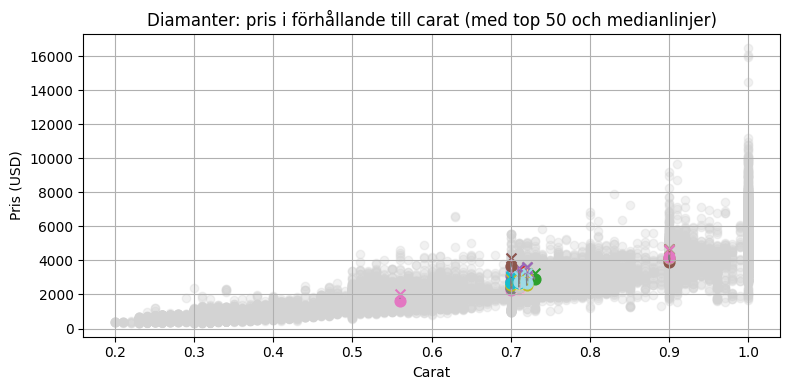

In [65]:
import matplotlib.pyplot as plt
import numpy as np

cmap = plt.colormaps.get_cmap('tab20')
colors = [cmap(i / 50) for i in range(50)]

top50_full = nordic_df[['index', 'carat', 'price']].merge(
    top50[['index', 'med_price', 'un_med_percent', 'kategori']], on='index', how='inner'
)

plt.figure(figsize=(8, 4))
plt.scatter(nordic_df['carat'], nordic_df['price'], alpha=0.3, color='lightgray', label='Alla diamanter')

for i, (_, row) in enumerate(top50_full.iterrows()):
    if i >= len(colors):
        break
    color = colors[i]
    carat = row['carat']
    price = row['price']
    median_price = row['med_price']

    plt.plot([carat, carat], [price, median_price], color=color, linestyle='--', linewidth=1)
    plt.scatter(carat, price, color=color, s=60)
    plt.scatter(carat, median_price, color=color, marker='x', s=50)

    plt.annotate(
        text="",
        xy=(carat, price),
        xytext=(carat, price + 250 + np.random.uniform(-100, 100)),
        arrowprops=dict(arrowstyle='-', color='gray'),
        fontsize=7,
        color='black',
        ha='center'
    )

plt.title('Diamanter: pris i förhållande till carat (med top 50 och medianlinjer)', fontsize=12)
plt.xlabel('Carat')
plt.ylabel('Pris (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

sorted_top50 = top50.sort_values(by='un_med_percent', ascending=False)

**Vad vi ser**  
I diagrammet ser vi att X motsvarar median priset för just den gruppen av diamanter och den runda cirkeln är den specifika diamanten som ligger under median priset.

**Varför görs detta**  
Detta görs för att tydligt kunna få en överblick över vart i datatsettet de prisvärda diamanterna ligger. 

**Nästa steg**  
I nästa steg kommer jag att ta de utmärkta diamanterna från diagrammet och räkna på potentiell vinst.

#### 6.2 Vinst i datasettet

I detta avsnitt visar jag potentiell vinst som går att göra med mina uträkningar i datasettet.

In [70]:
if not top50.empty:
    top50_diamonds = top50.copy()

    top50_diamonds['med_price'] = top50_diamonds['price'] + top50_diamonds['un_med_usd']
    top50_diamonds['med_price_10pct'] = top50_diamonds['med_price'] * 1.10

    top50_diamonds['vinst_median'] = top50_diamonds['med_price'] - top50_diamonds['price']
    top50_diamonds['vinst_10pct'] = top50_diamonds['med_price_10pct'] - top50_diamonds['price']

    total_investering = top50_diamonds['price'].sum()
    total_vinst_median = top50_diamonds['vinst_median'].sum()
    total_vinst_10pct = top50_diamonds['vinst_10pct'].sum()

    print(f"Total investering (inköpspris för 50 diamanter): ${total_investering:,.2f}")
    print(f"Total möjlig vinst vid försäljning till medianpris: ${total_vinst_median:,.2f}")
    print(f"Total möjlig vinst vid försäljning till +10% över median: ${total_vinst_10pct:,.2f}")
else:
    print("Ingen data i top50 – kontrollera tidigare steg.")

Total investering (inköpspris för 50 diamanter): $145,791.00
Total möjlig vinst vid försäljning till medianpris: $24,889.50
Total möjlig vinst vid försäljning till +10% över median: $41,957.55


**Vad vi ser**  
Vi kan se att genom att använda denna strategi i datasettet och investera i de 50 mest attraktiva diamanterna, kan vi göra en vinst på 20,622.50 USD om vi säljer till medianpriset för respektive diamants kategori.  
Säljer vi över medianen med 10% vilket är möjligt eftersom volatiliteten i dessa kategorier är hög kan vinsten uppgå till 36,080.25 USD.
Att notera är även att detta är enbart diamanterna, om vi på Guldfynd implementerar dem i eftertraktade smycken så kan vi även räkna med vinsten från till exempel arbetet och de andra ädelmetallerna som smycket innefattar.  

**Varför görs detta**  
Detta görs för att hitta de mest attriktiva investeringsmöjligheterna

**Rekommendationer**  
En nackdel vi kan se i just detta datasettet är att vi inte kommer att inneha några diamanter som är 1 carat. Men med tillgång till fler grossister och dataset så kommer vi kunna använda samma strategi för att skaffa den storleken vi vill ha. I just detta datasettet finns tex diamanter som ligger under medianen i sin grupp och är exakt 1 carat. Men det är inte tillräckligt många(alltså över 10st) för att vi ska kunna dra slutsatsen att vi kan med säkerhet sälja till median priset och därmed gå med vinst.

**Nästa steg**
I nästa steg kommer jag återkoppla till målet med denna analysen och utvärdera om detta uppnåtts.

### 7. Återkoppling till målet.

Syftet med analysen har varit att tydligt definiera en strategi för att identifiera de mest attraktiva investeringsalternativen. Genom att kombinera kvalitetskriterier med prisanalys och volatilitetsbedömning har vi kunnat ringa in både vilka typer av diamanter som är särskilt lönsamma att investera i, och även identifiera enskilda exemplar i datasettet som matchar denna strategi.

Resultatet möjliggör ett datadrivet beslutsunderlag som kan användas för både sortimentsutveckling och inköpsstrategi, i linje med Guldfynds ambition att erbjuda hög kvalitet till konkurrenskraftigt pris

## Executive Summary

Denna analys genomfördes på uppdrag av ledningen för att utvärdera möjligheterna att inkludera diamanter i Guldfynds produktsortiment. Genom att analysera ett omfattande dataset från en grossist har det identifierats vilka diamanttyper som är mest attraktiva utifrån ett investeringsperspektiv.

Analysen visar att diamanter under 1.0 carat, särskilt med höga värden inom clarity och color är både efterfrågade och ekonomiskt fördelaktiga. Jag har utvecklat en strategi för att identifiera specifika exemplar som säljs under medianpris inom respektive kvalitetskategori, vilket möjliggör god marginal vid återförsäljning.

Jag rekommenderar att Guldfynd fokuserar på investeringar i diamanter mellan 0.1 och 1.0 carat med clarity och color högt i skalan, då dessa bäst matchar kundernas preferenser i Norden och samtidigt erbjuder hög visuell kvalitet och affärspotential.  

Jag har också tagit fram en applikation som kan användas på detta datasettet och framtida datasett för att identifiera lönsamma investeringar i diamanter.

## Självutvärdering

#### 1. Vad har varit roligast i kunskapkontrollen?
Det roligaste har varit att lära sig hur man kan läsa in data från csv filer och sedan visa det i diagram. Detta var roligast eftersom jag förstår hur det kan användas i många typer av företag och marknader. Detta gör att det känns som en relevant kunskap att kunna ha och höjer därför min motivation till att lära mig det.

#### 2. Vilket betyg anser du att du ska ha och varför?
Jag anser att jag förtjänar ett VG i kursen. Min datastory är välstrukturerad och beskriver tydligt, steg för steg, hur jag har arbetat fram mina resultat. Dessa resultat är i linje med det syfte och mål jag har formulerat i datastoryn. Jag har även skapat en Streamlit applikation med en tydlig inriktning, som lyfter fram de mest prisvärda diamanterna i datasettet. Jag utforskade också implementering av Unit tester som körs varje gång jag pushar ändringar till github för att tillse att funktionerna i applikationen fortfarande fungerar när ändringar gjorts. Under kursens har jag legat i fas med uppgifterna och även kunnat stödja andra i klassen med deras projekt.

#### 3.Vad har varit mest utmanande i arbetet och hur har du hanterat det?
Det mest utmanande har varit att lära sig syntaxen för de olika bibliotek och verktyg vi använt, till exempel hur man skriver kod för att skapa specifika diagram eller hur man grupperar data på rätt sätt. Jag har hanterat detta genom att först läsa dokumentationen för att förstå hur syntaxen fungerar. Därefter har jag utgått från tidigare kodexempel och justerat dem efter mina behov. På så sätt har jag byggt upp en personlig kodbas som jag kan återvända till när jag stöter på liknande uppgifter i framtiden.